**Data mining Project - University of Pisa, acedemic year 2023/24**
 
**Authors**: Giacomo Aru, Giulia Ghisolfi, Luca Marini, Irene Testa

# Support Vector Machine

SVM is a supervised learning model used for both tasks of regression and classification. SVMs are able to perform non-linear classification using kernel methods, which map the input in a multi-dimensional space and perform operations on it, without the need of actually manage a bigger dimensional space (everything is performed in input space).
In our case, we can compare it to other classification models (like linear) becouse it works by creating a division bound to separate the samples in a certain number of classes, but thanks to kernel methods it's generally able to reach better performances.

In [4]:
import pandas as pd
import json
import pickle
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV,  KFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.inspection import permutation_importance
from time import time
from classification_utils import *
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
RESULTS_DIR = '../data/classification_results'
clf_name = 'SupportVectorMachineClassifier'
SEED=42

We load the dataset and the features used for classification.

In [5]:
# load the data
incidents_train_df = pd.read_csv('../data/clf_indicators_train.csv', index_col=0)
incidents_test_df = pd.read_csv('../data/clf_indicators_test.csv', index_col=0)
true_labels_train_df = pd.read_csv('../data/clf_y_train.csv', index_col=0)
true_labels_train = true_labels_train_df.values.ravel()
true_labels_test_df = pd.read_csv('../data/clf_y_test.csv', index_col=0)
true_labels_test = true_labels_test_df.values.ravel()

# load the names of the features to use for the classification task
features_for_clf = json.loads(open('../data/clf_indicators_names_distance_based.json').read())

# project on the features to use
indicators_train_df = incidents_train_df[features_for_clf]
indicators_test_df = incidents_test_df[features_for_clf]

We display the features names we will use.

In [3]:
print(features_for_clf)
print(f'Number of features: {len(features_for_clf)}')

['location_imp', 'x', 'y', 'age_range', 'avg_age', 'n_child_prop', 'n_teen_prop', 'n_males_prop', 'n_participants', 'day_x', 'day_y', 'day_of_week_x', 'day_of_week_y', 'month_x', 'month_y', 'year', 'days_from_first_incident', 'poverty_perc', 'democrat', 'gun_law_rank', 'aggression', 'accidental', 'defensive', 'suicide', 'road', 'house', 'school', 'business', 'illegal_holding', 'drug_alcohol', 'officers', 'organized', 'social_reasons', 'abduction']
Number of features: 34


We make a 2-fold cross validation in which we check which is the best value for each hyperparameter (*kernel*, *C*, *gamma*, *degree*, *class_weight*). The parameters we select in this section are chosen on the basis of previous test, looking at the ones which performed better. <br>
The values for training are scaled to be between 0 and 1 so that bigger values in module, and so bigger distances, don't affect the classification.
In this case we usa only 2 folds becouse otherwise the time to fit all the models will be huge.

In [16]:
cv = KFold(n_splits=2, shuffle=True, random_state=SEED)
scaler = MinMaxScaler()
svc = SVC()
pipe = Pipeline(steps=[('scaler', scaler), ('svc', svc)])

param_grid = [
    {
        'svc__kernel': ['poly', 'rbf'],
        'svc__C': [0.1, 1, 2, 3.5, 5],
        'svc__gamma': ['scale', 'auto'],
        'svc__degree': [3, 4],
        'svc__class_weight': ['balanced']
    }
]

gs = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    n_jobs=-1,
    scoring=make_scorer(f1_score),
    verbose=10,
    cv=cv,
    refit=False,
)
gs.fit(indicators_oversampled_train_df, true_oversampled_labels_train)

Fitting 2 folds for each of 40 candidates, totalling 80 fits


GridSearchCV(cv=KFold(n_splits=2, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid=[{'svc__C': [0.1, 1, 2, 3.5, 5],
                          'svc__class_weight': ['balanced'],
                          'svc__degree': [3, 4],
                          'svc__gamma': ['scale', 'auto'],
                          'svc__kernel': ['poly', 'rbf']}],
             refit=False, scoring=make_scorer(f1_score), verbose=10)

We display some metrics derived from cross validation fitting.

In [17]:
cv_results_df = pd.DataFrame(gs.cv_results_)
cv_results_df.columns = [col.replace('svc__', '') for col in cv_results_df.columns]
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_degree,param_gamma,param_kernel,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,411.697016,1.934491,142.441395,1.134942,0.1,balanced,3,scale,poly,"{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.646515,0.647127,0.646821,0.000306,18
1,483.686846,1.564415,500.468528,2.607908,0.1,balanced,3,scale,rbf,"{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__gamma': 'scale', 'svc__kernel': 'rbf'}",0.634730,0.638478,0.636604,0.001874,29
2,531.230141,1.231079,202.499820,0.503166,0.1,balanced,3,auto,poly,"{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__gamma': 'auto', 'svc__kernel': 'poly'}",0.621323,0.624621,0.622972,0.001649,39
3,510.089993,2.082893,550.517975,1.255199,0.1,balanced,3,auto,rbf,"{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__degree': 3, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}",0.625083,0.627735,0.626409,0.001326,37
4,407.439102,1.807060,147.039694,1.189987,0.1,balanced,4,scale,poly,"{'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__degree': 4, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}",0.647879,0.650645,0.649262,0.001383,17


We plot the heatmap of the scores, on the test set, archieved by each classifier with different paramenters. It gives an idea of the importance of each parameter and the variation of the performance in changing their values.

<Axes: title={'center': "param_gamma='auto'"}, xlabel='param_kernel', ylabel='param_C'>

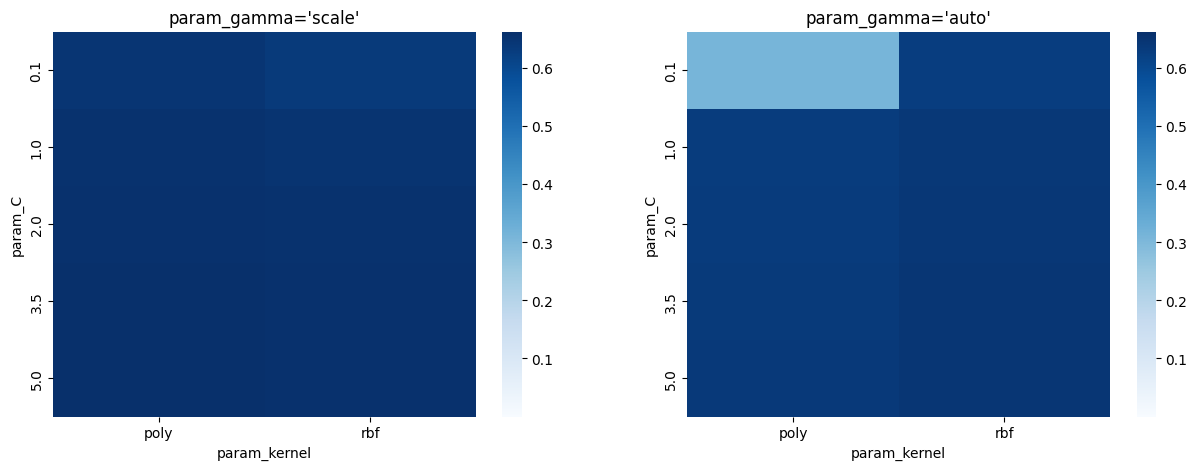

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
pvt_scale = pd.pivot_table(
    cv_results_df[(cv_results_df['param_gamma'] == 'scale')],
    values='mean_test_score',
    index=['param_C'],
    columns=['param_kernel']
)
pvt_auto = pd.pivot_table(
    cv_results_df[(cv_results_df['param_gamma'] == 'auto')],
    values='mean_test_score',
    index=['param_C'],
    columns=['param_kernel']
)
min_score = cv_results_df['mean_test_score'].min()
max_score = cv_results_df['mean_test_score'].max()
axs[0].set_title("param_gamma='scale'")
axs[1].set_title("param_gamma='auto'")
sns.heatmap(pvt_scale, cmap='Blues', ax=axs[0], vmin=min_score, vmax=max_score)
sns.heatmap(pvt_auto, cmap='Blues', ax=axs[1], vmin=min_score, vmax=max_score)

From the heatmap we can see the models have similiar scores for all the hyperparameters combinations we chose. This was expected since we selected the best one from previous tests. We can also see that generally **scaled gamma** behaves quite well with every combination of other hyperparameter, while gamma set to **auto** struggles with low values of **C**.

We display the mean and standard deviation of the score of the models fitted in the cross validation. These values are calculated on the test set.

In [19]:
params = [col for col in cv_results_df.columns if 'param_' in col and 'random' not in col]
cv_results_df.sort_values(
    by='mean_test_score',
    ascending=False)[params+['std_test_score', 'mean_test_score']].head(20).style.background_gradient(subset=['std_test_score', 'mean_test_score'], cmap='Blues')

,param_C,param_class_weight,param_degree,param_gamma,param_kernel,std_test_score,mean_test_score
28,3.500000,balanced,4,scale,poly,0.001087,0.662482
36,5,balanced,4,scale,poly,0.001113,0.662235
20,2,balanced,4,scale,poly,0.001305,0.661115
32,5,balanced,3,scale,poly,0.002700,0.659831
12,1,balanced,4,scale,poly,0.002489,0.659433
24,3.500000,balanced,3,scale,poly,0.001764,0.659065
37,5,balanced,4,scale,rbf,0.002750,0.658641
33,5,balanced,3,scale,rbf,0.002750,0.658641
29,3.500000,balanced,4,scale,rbf,0.002669,0.657335
25,3.500000,balanced,3,scale,rbf,0.002669,0.657335


Here is even more clear that **gamma scaled** has slightly better performance in general. Moreover we see that for the best choices of C and param_degree, **polynomial kernel** behaves slightly better than gaussian one.

We make a random oversampling on the positive class such that fatal incidents become 40% of the total number of records. Doing oversampling we can help classifier make better predictions on test set, but we don't reach a 50-50 ratio since it may be unrealistic.

We fit the best model we got from cross validation, then we make and save the predictions on test set. Finally we save the models so that we can reuse it without performing the training.

In [21]:
best_index = gs.best_index_
best_model_params = cv_results_df.loc[best_index]['params']
best_model_params = {k.replace('svc__', ''): v for k, v in best_model_params.items()}
best_model_params['probability'] = True
best_model = SVC(**best_model_params)
best_model_oversampled = SVC(**best_model_params)
best_model_smote = SVC(**best_model_params)

# scale all the data
minmax_scaler = MinMaxScaler()
indicators_train_scaled = minmax_scaler.fit_transform(indicators_train_df)
indicators_oversampled_train_scaled = minmax_scaler.fit_transform(indicators_oversampled_train_df)
indicators_smote_train_scaled = minmax_scaler.fit_transform(indicators_smote_train_df)
indicators_test_scaled = minmax_scaler.fit_transform(indicators_test_df)


# fit the model on all the training data
fit_start = time()
best_model.fit(indicators_train_scaled, true_labels_train)
fit_time = time()-fit_start

# fit the model on all the training data (oversampled)
fit_start = time()
best_model_oversampled.fit(indicators_oversampled_train_scaled, true_oversampled_labels_train)
fit_time_oversampled = time()-fit_start

# fit the model on all the training data (smote)
fit_start = time()
best_model_smote.fit(indicators_smote_train_scaled, true_labels_smote_train)
fit_time_smote = time()-fit_start


# get the predictions on the training data
train_score_start = time()
pred_labels_train = best_model.predict(indicators_train_scaled)
train_score_time = time()-train_score_start
pred_probas_train = best_model.predict_proba(indicators_train_scaled)

# get the predictions on the training data (oversampled)
train_score_start = time()
pred_labels_oversampled_train = best_model_oversampled.predict(indicators_oversampled_train_scaled)
train_score_time_oversampled = time()-train_score_start
pred_probas_oversampled_train = best_model_oversampled.predict_proba(indicators_oversampled_train_scaled)

# get the predictions on the training data (smote)
train_score_start = time()
pred_labels_smote_train = best_model_smote.predict(indicators_smote_train_scaled)
train_score_time_smote = time()-train_score_start
pred_probas_smote_train = best_model_smote.predict_proba(indicators_smote_train_scaled)


# get the predictions on the test data
test_score_start = time()
pred_labels_test = best_model.predict(indicators_test_scaled)
test_score_time = time()-test_score_start
pred_probas_test = best_model.predict_proba(indicators_test_scaled)

# get the predictions on the test data (oversampled)
test_score_start = time()
pred_labels_oversampled_test = best_model_oversampled.predict(indicators_test_scaled)
test_score_time_oversampled = time()-test_score_start
pred_probas_oversampled_test = best_model_oversampled.predict_proba(indicators_test_scaled)

# get the predictions on the test data (smote)
test_score_start = time()
pred_labels_smote_test = best_model_smote.predict(indicators_test_scaled)
test_score_time_smote = time()-test_score_start
pred_probas_smote_test = best_model_smote.predict_proba(indicators_test_scaled)


# save the predictions
pd.DataFrame(
    {'labels': pred_labels_test, 'probs': pred_probas_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_preds.csv')

# save the predictions (oversampled)
pd.DataFrame(
    {'labels': pred_labels_oversampled_test, 'probs': pred_probas_oversampled_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_oversampled_preds.csv')

# save the predictions (smote)
pd.DataFrame(
    {'labels': pred_labels_smote_test, 'probs': pred_probas_smote_test[:,1]}
).to_csv(f'{RESULTS_DIR}/{clf_name}_smote_preds.csv')


# save the model
file = open(f'{RESULTS_DIR}/{clf_name}.pkl', 'wb')
pickle.dump(obj=best_model, file=file)
file.close()

# save the model (oversampled)
file = open(f'{RESULTS_DIR}/{clf_name}_oversampled.pkl', 'wb')
pickle.dump(obj=best_model_oversampled, file=file)
file.close()

# save the model (smote)
file = open(f'{RESULTS_DIR}/{clf_name}_smote.pkl', 'wb')
pickle.dump(obj=best_model_smote, file=file)
file.close()


# save the cv results
best_model_cv_results = pd.DataFrame(cv_results_df.iloc[best_index]).T
best_model_cv_results.index = [clf_name]
best_model_cv_results.to_csv(f'{RESULTS_DIR}/{clf_name}_train_cv_scores.csv')

We display some classification scores in order to have some metrics useful to make comparisions with other models. These scores are refearing to predictions on training and test set including oversampled and smote.

In [22]:
compute_clf_scores(
    y_true=true_labels_train,
    y_pred=pred_labels_train,
    train_time=fit_time,
    score_time=train_score_time,
    params=best_model_params,
    prob_pred=pred_probas_train,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
SupportVectorMachineClassifier,0.863498,0.689312,0.766636,0.538079,0.768589,0.633002,0.700789,0.728951,0.699819,0.759321,0.714692,0.723855,0.714692,0.810711,11053.769681,267.735998,"{'C': 3.5, 'class_weight': 'balanced', 'degree': 4, 'gamma': 'scale', 'kernel': 'poly', 'probability': True}"


In [23]:
compute_clf_scores(
    y_true=true_oversampled_labels_train,
    y_pred=pred_labels_oversampled_train,
    train_time=fit_time_oversampled,
    score_time=train_score_time_oversampled,
    params=best_model_params,
    prob_pred=pred_probas_oversampled_train,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_oversampled_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
SupportVectorMachineClassifier,0.823385,0.689546,0.750546,0.625605,0.77814,0.693585,0.724495,0.733843,0.722065,0.744273,0.724984,0.727761,0.724984,None,17900.816297,350.245533,"{'C': 3.5, 'class_weight': 'balanced', 'degree': 4, 'gamma': 'scale', 'kernel': 'poly', 'probability': True}"


In [24]:
compute_clf_scores(
    y_true=true_labels_smote_train,
    y_pred=pred_labels_smote_train,
    train_time=fit_time_smote,
    score_time=train_score_time_smote,
    params=best_model_params,
    prob_pred=pred_probas_smote_train,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_smote_train_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
SupportVectorMachineClassifier,0.831305,0.731913,0.778449,0.659021,0.777212,0.713254,0.745163,0.754563,0.745852,0.762392,0.750033,0.752371,0.750033,None,15547.173946,310.776001,"{'C': 3.5, 'class_weight': 'balanced', 'degree': 4, 'gamma': 'scale', 'kernel': 'poly', 'probability': True}"


In [25]:
compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_test,
    train_time=fit_time,
    score_time=test_score_time,
    params=best_model_params,
    prob_pred=pred_probas_test,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_test_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
SupportVectorMachineClassifier,0.846426,0.655458,0.738801,0.505303,0.747427,0.602966,0.675865,0.701442,0.670884,0.737225,0.684899,0.695317,0.684899,0.776488,11053.769681,133.445976,"{'C': 3.5, 'class_weight': 'balanced', 'degree': 4, 'gamma': 'scale', 'kernel': 'poly', 'probability': True}"


In [34]:
compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_oversampled_test,
    train_time=fit_time_oversampled,
    score_time=train_score_time_oversampled,
    params=best_model_params,
    prob_pred=pred_probas_oversampled_test,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_oversampled_test_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
SupportVectorMachineClassifier,0.846793,0.653988,0.738005,0.504665,0.748704,0.602927,0.675729,0.701346,0.670466,0.73727,0.684309,0.694764,0.684309,0.776209,17900.816297,350.245533,"{'C': 3.5, 'class_weight': 'balanced', 'degree': 4, 'gamma': 'scale', 'kernel': 'poly', 'probability': True}"


In [33]:
compute_clf_scores(
    y_true=true_labels_test,
    y_pred=pred_labels_smote_test,
    train_time=fit_time_smote,
    score_time=train_score_time_smote,
    params=best_model_params,
    prob_pred=pred_probas_smote_test,
    clf_name=clf_name,
    path=f'{RESULTS_DIR}/{clf_name}_smote_test_scores.csv'
)

,precision-Non-Fatal,recall-Non-Fatal,f1-score-Non-Fatal,precision-Fatal,recall-Fatal,f1-score-Fatal,precision-macro avg,recall-macro avg,f1-score-macro avg,precision-weighted avg,recall-weighted avg,f1-score-weighted avg,accuracy,auroc,train_time,score_time,params
SupportVectorMachineClassifier,0.827384,0.705729,0.76173,0.523748,0.6873,0.59448,0.675566,0.696515,0.678105,0.730183,0.69983,0.708189,0.69983,0.77372,15547.173946,310.776001,"{'C': 3.5, 'class_weight': 'balanced', 'degree': 4, 'gamma': 'scale', 'kernel': 'poly', 'probability': True}"


Since the model with better performance (better f1-score macro) is the one trained on smote oversampled data, we will use it for further analisys.

We plot the diffusion matrix in orther to know what is the balancing between false positves, false negatives, true positives and true negatives.

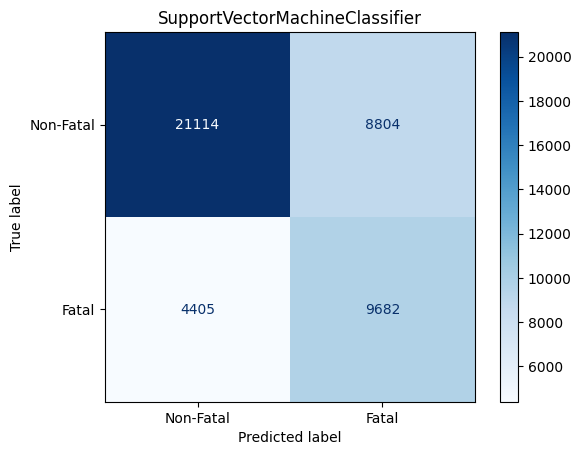

In [28]:
plot_confusion_matrix(
    y_true=true_labels_test,
    y_pred=pred_labels_smote_test,
    title=clf_name
)

We can see that the model manage to recognize most of the fatal incidents, however, the number of FP (for fatal incidents) is almost the same of the TP.

We plot the classification labels in the bidimensional feature spaces obtained pairing 4 features: **aggression**, **drug_alcohol**, **gun_law_rank** and **n_males**.

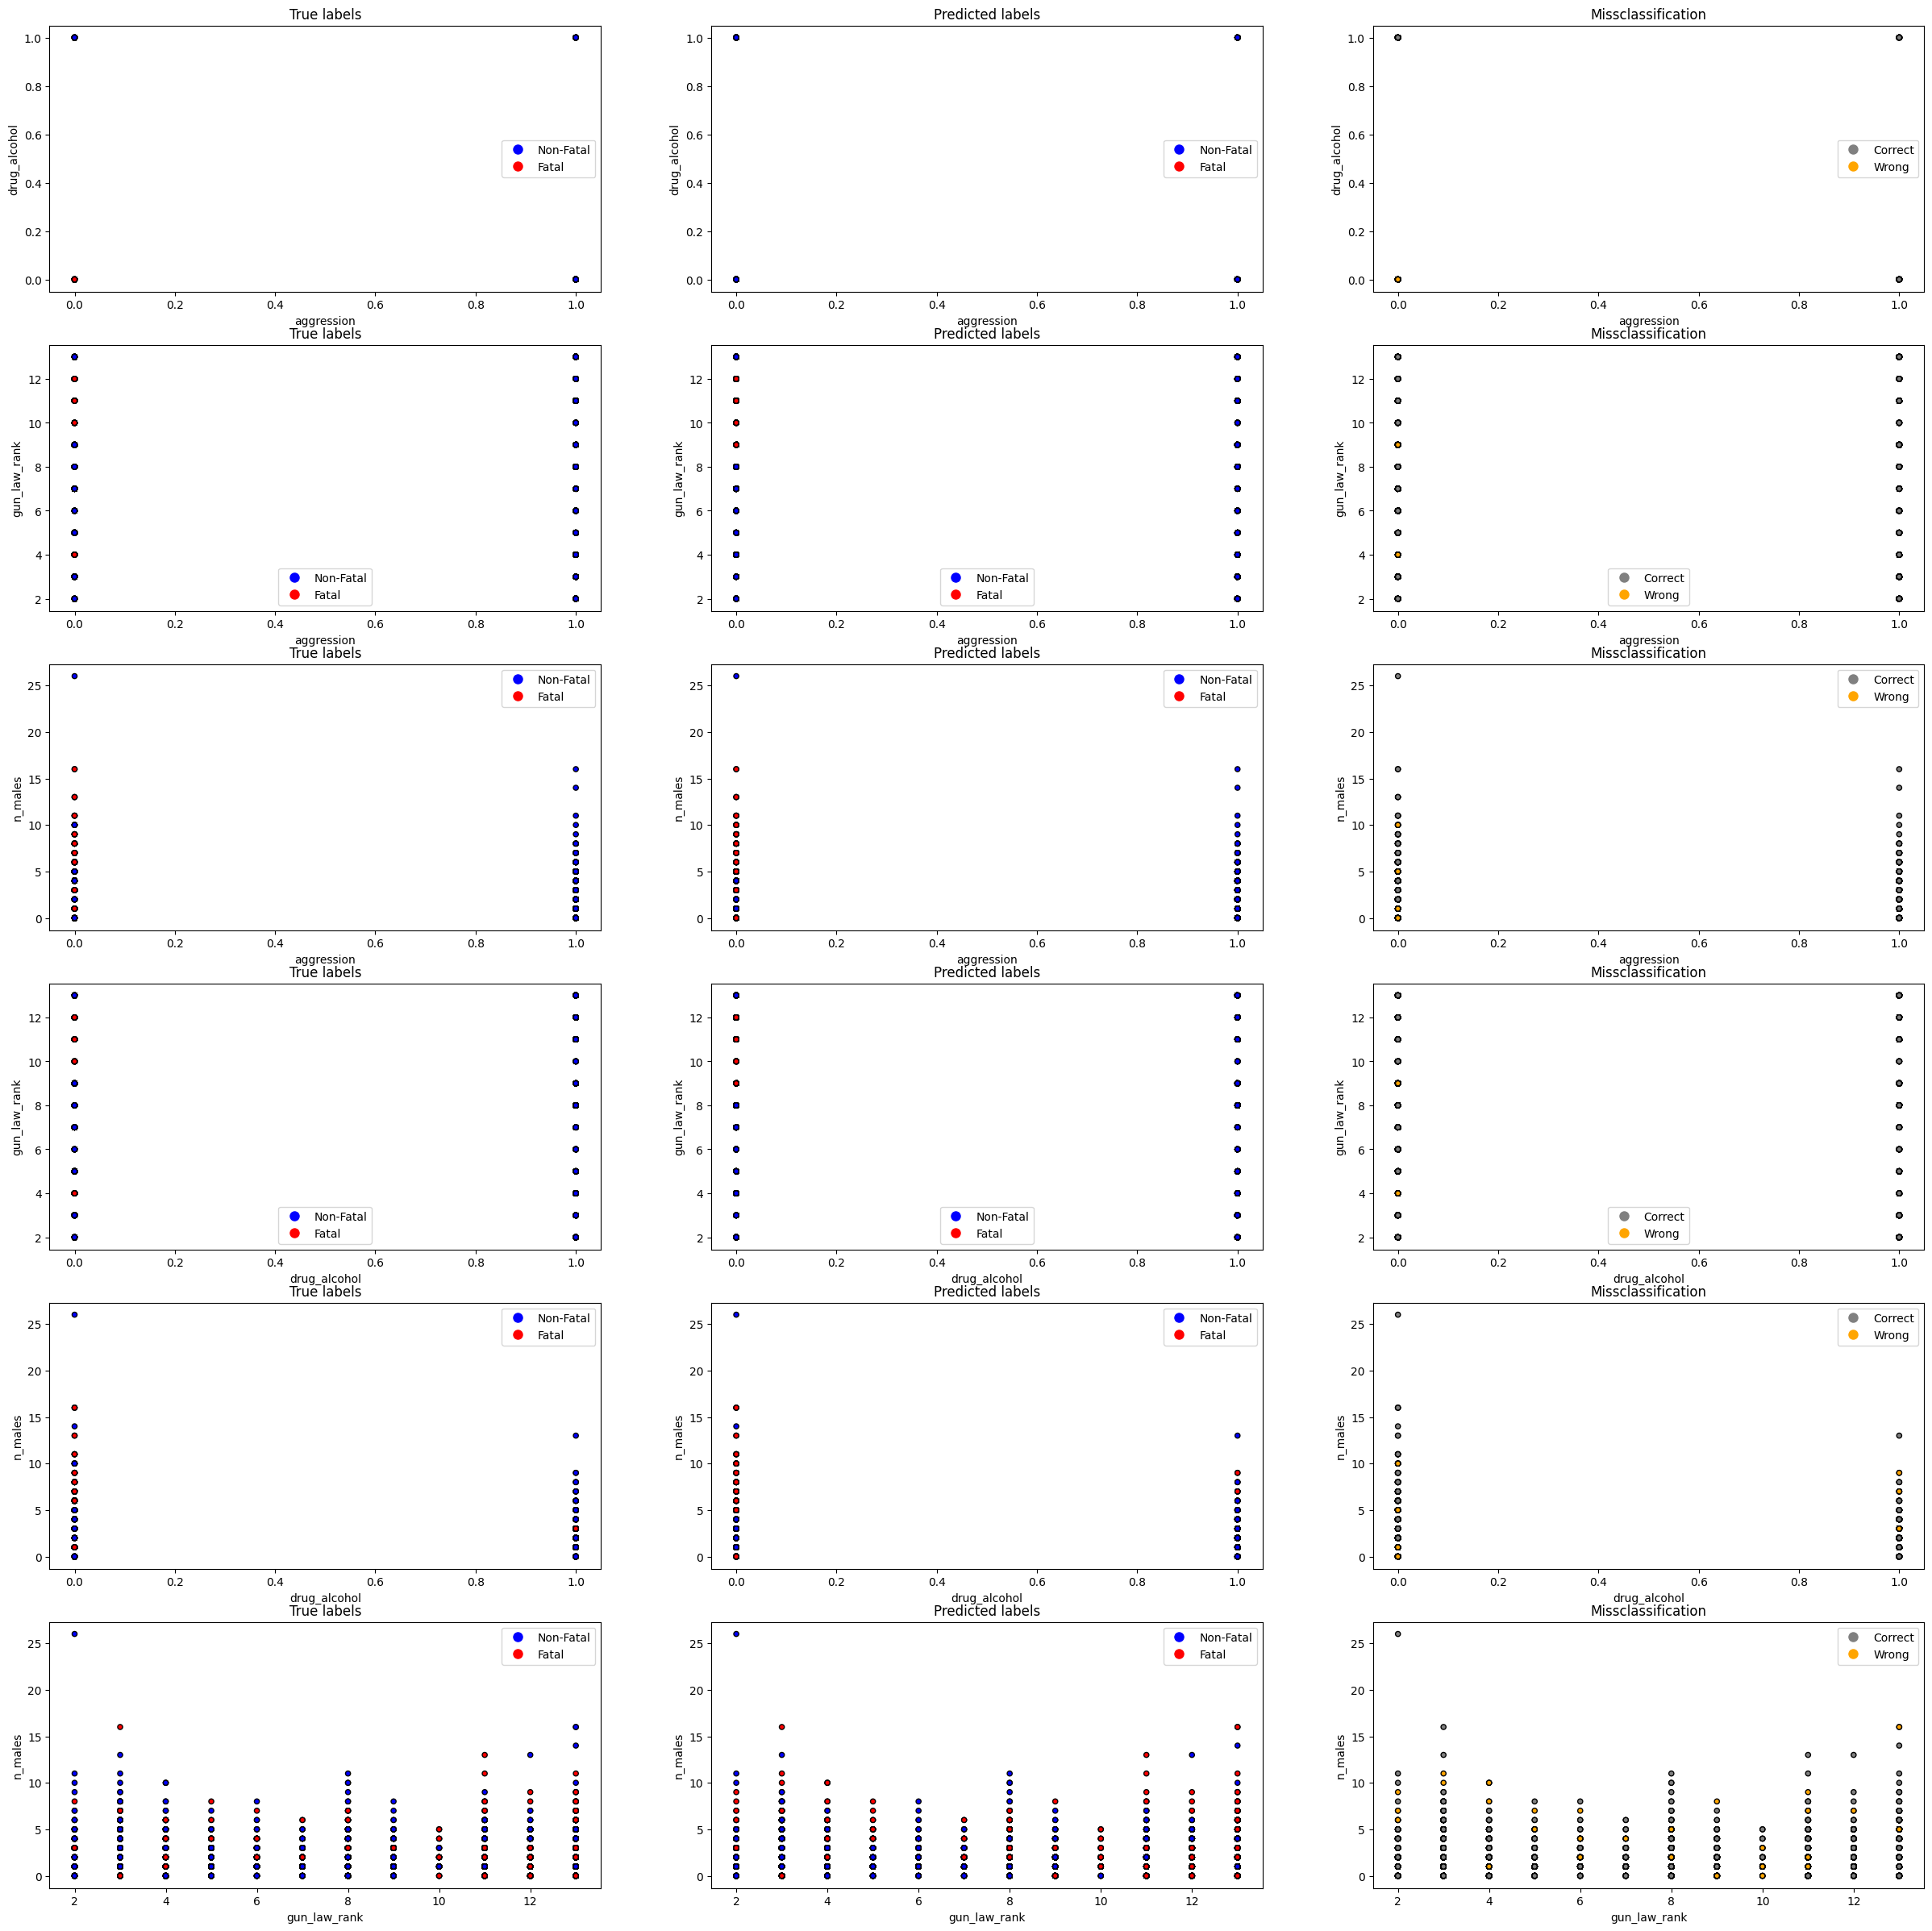

In [38]:
plot_predictions_in_features_space(
    df=incidents_test_df,
    features=['aggression', 'drug_alcohol', 'gun_law_rank', 'n_males'],
    true_labels=true_labels_test,
    pred_labels=pred_labels_smote_test,
    figsize=(30, 30)
)

Given the plot, although we can't deduce anything on the separation of clusters, we can notice that when **aggression** and **drug_alcohol** are set to 1, the incidents are generally not fatal and the model recognize this pattern.

We plot the ROC curve of the model basing on its prediction on test set.

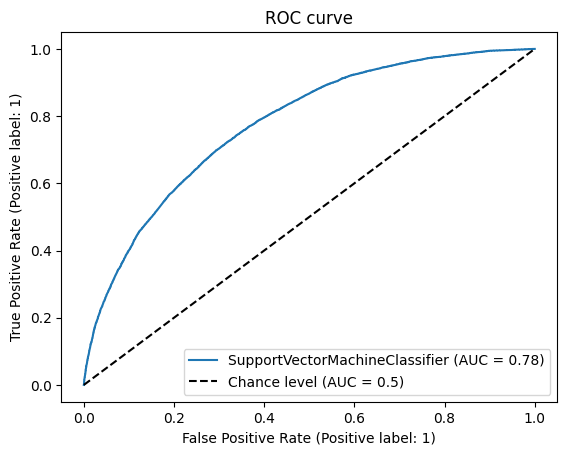

In [31]:
plot_roc(y_true=true_labels_test, y_probs=[pred_probas_smote_test[:,1]], names=[clf_name])

We permorm PCA and we plot the decision boundary of the first two components.

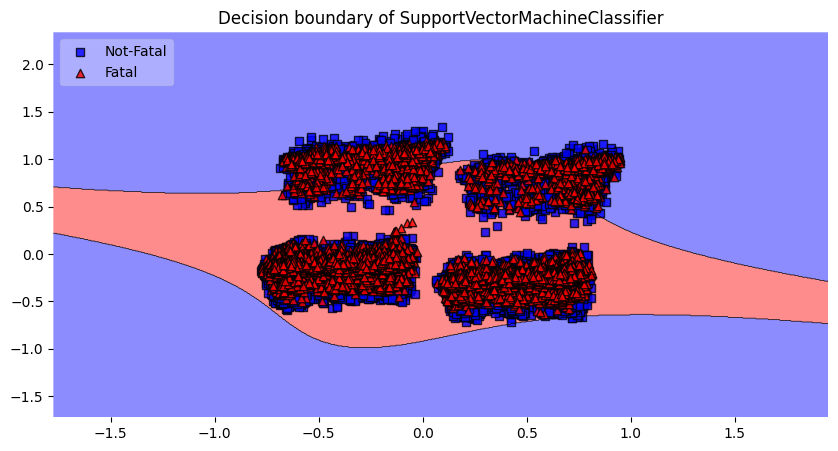

In [35]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_PCA_decision_boundary(
  train_set=indicators_smote_train_scaled,
  features=indicators_train_df.columns, # TODO: eventualmente usare solo le numeriche
  train_label=true_labels_smote_train,
  classifier=best_model_smote,
  classifier_name=clf_name,
  axs=axs
)

As results we have a very smooth decision boundary in the feature space.

We plot the learning curve of the model. Each time we perform training in a subsample of the dataset and see how the results vary.

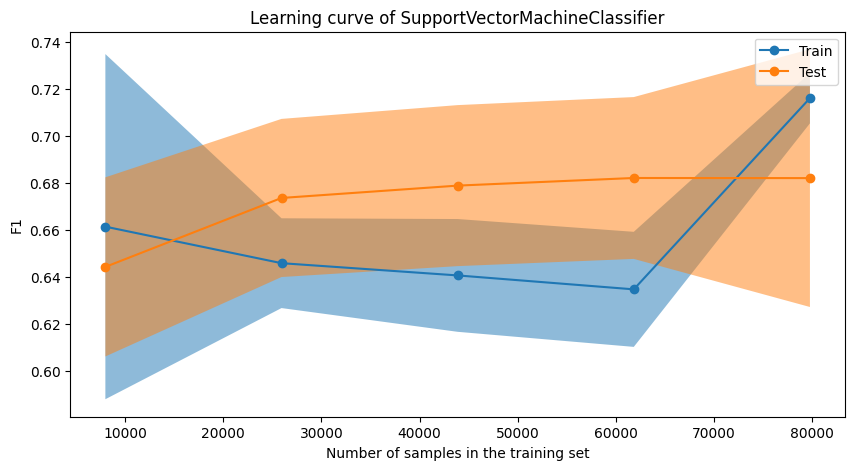

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_learning_curve(
    classifier=best_model_smote,
    classifier_name=clf_name,
    train_set=indicators_smote_train_scaled,
    labels=true_labels_smote_train,
    ax=axs,
    train_sizes=np.linspace(0.1, 1.0, 5),
    metric='f1'
)

While the test score has a smooth increasing curve, F1 on training tends to linearly decrease until at the end there is peak at 80k samples where the score comes back to be better on training than on test (as it was at first iteration). Standard deviation is higher on test, in particular in last iteration, while on training it's very high only at the beginning.

We plot the curve of the F1 score for different values of C.

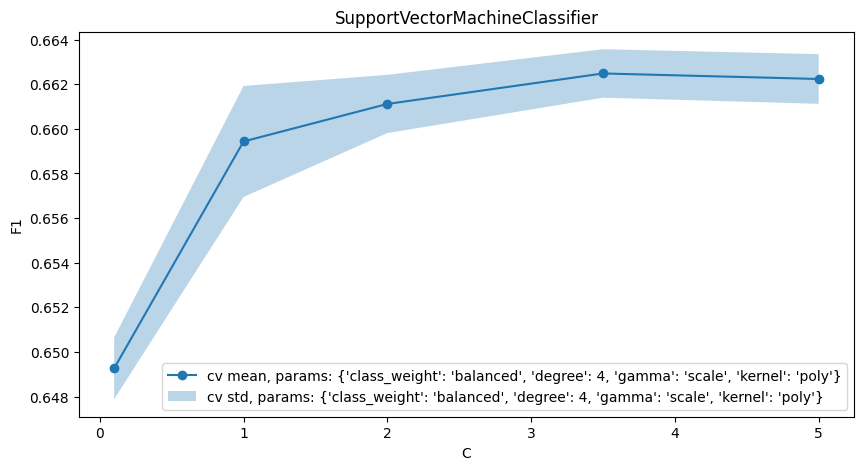

In [39]:
param_of_interest = 'C'
fixed_params = best_model_params.copy()
fixed_params.pop(param_of_interest)
fixed_params.pop('probability')
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
plot_scores_varying_params(
    cv_results_df,
    param_of_interest,
    fixed_params,
    'F1',
    axs,
    title=clf_name
)

As we saw in cross validation results, scores on varying of C tends to increase until a certain point an then start to decrease (confirmed by previuos test and preliminary cross validations). The peak of performance is between 3 and 4.

Here we train a model to check which could be the most important and influent features for predictiong sample labels. We exploit the weights of an SVM with linear kernel, where the ones with higher weights are the ones which are more influent.

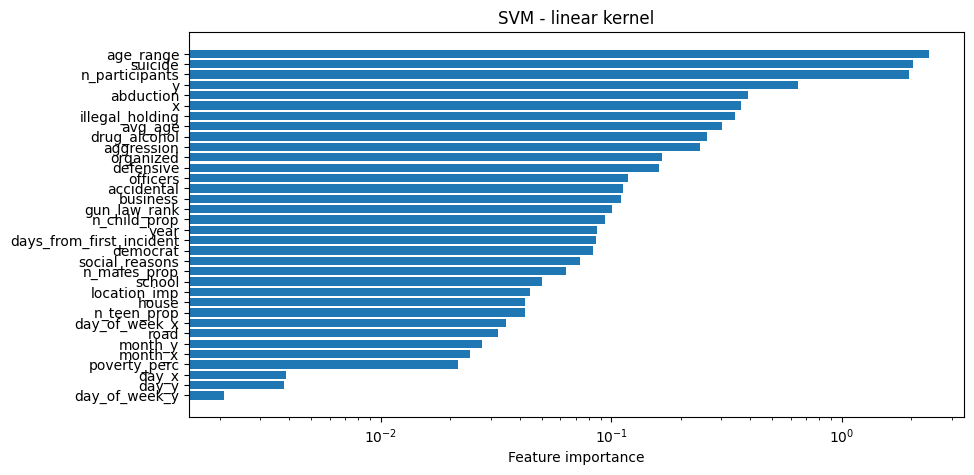

In [49]:
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
svc =  SVC(kernel='linear')
svc.fit(indicators_train_scaled, true_labels_train)
axs.set_xscale('log')
display_feature_importances(
    feature_names=indicators_train_df.columns,
    feature_importances=np.abs(svc.coef_[0]),
    axs=axs,
    title='SVM - linear kernel',
    path=f'{RESULTS_DIR}/{clf_name}_feature_importances.csv'
)

In [5]:
# train SVC with rbf kernel
svc =  SVC(kernel='rbf', gamma='scale', C=0.1)
svc.fit(indicators_train_scaled, true_labels_train)
# get features importances
perm_importance = permutation_importance(svc, indicators_train_scaled, true_labels_train, random_state = 42)
# plot features importances
fig, axs = plt.subplots(1, 1, figsize=(10, 5))
display_feature_importances(
    feature_names=indicators_train_df.columns,
    feature_importances=perm_importance['importances_mean'],
    axs=axs,
    title='SVM - rbf kernel',
    path=f'{RESULTS_DIR}/svm_rbf_feature_importances.csv'
)

We display with different types of plot the distribution of the values of the miscassified incidents of **n_killed**, **suicide**, **aggression**, **road** and **location_imp**.

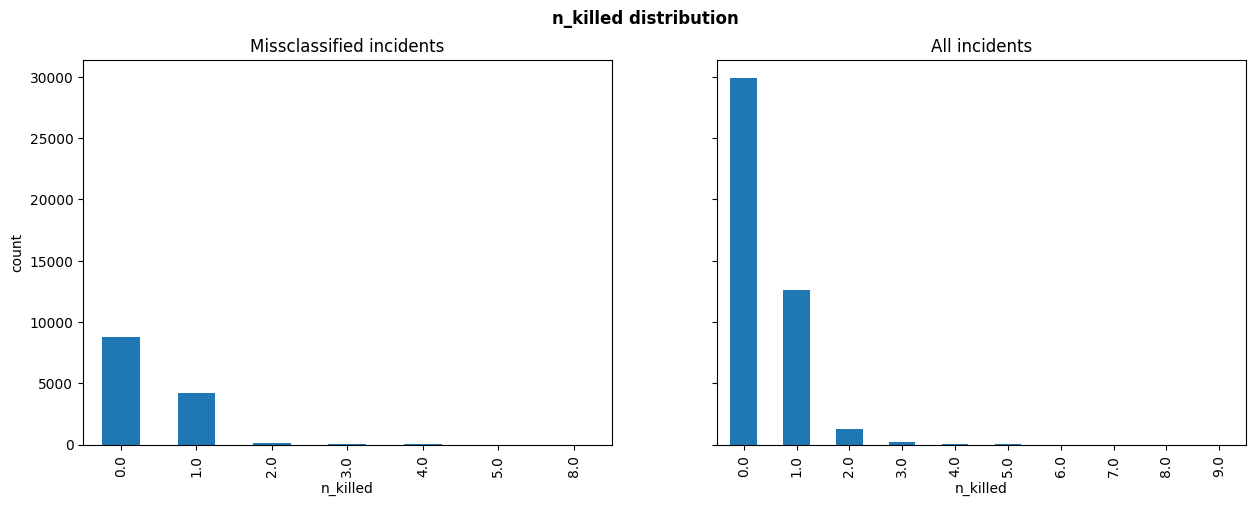

In [44]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_smote_test,
    incidents_test_df,
    'n_killed',
    'bar',
    title='n_killed distribution'
)

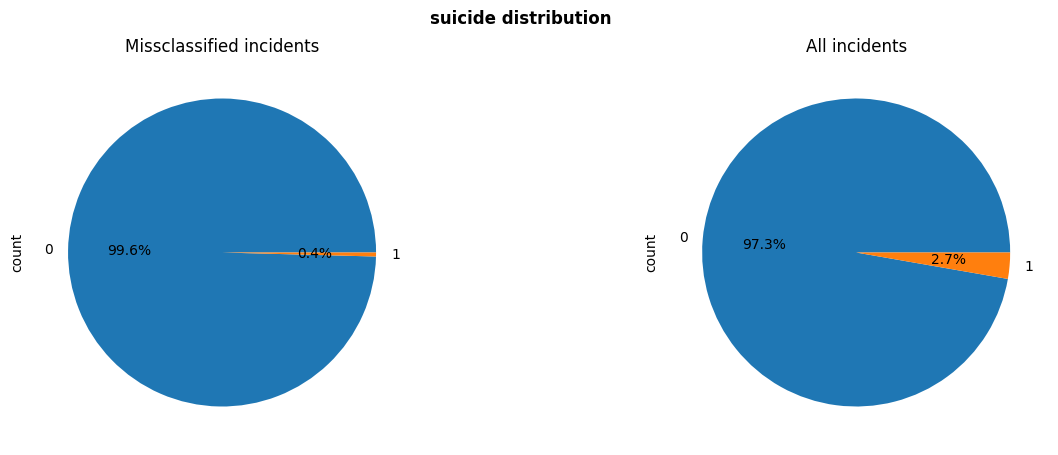

In [45]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_smote_test,
    incidents_test_df,
    'suicide',
    'pie',
    title='suicide distribution'
)

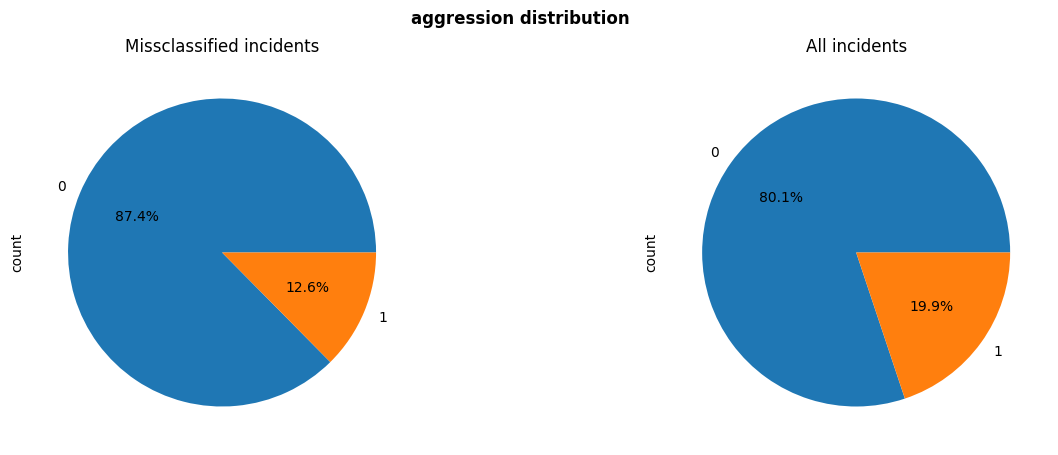

In [46]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_smote_test,
    incidents_test_df,
    'aggression',
    'pie',
    title='aggression distribution'
)

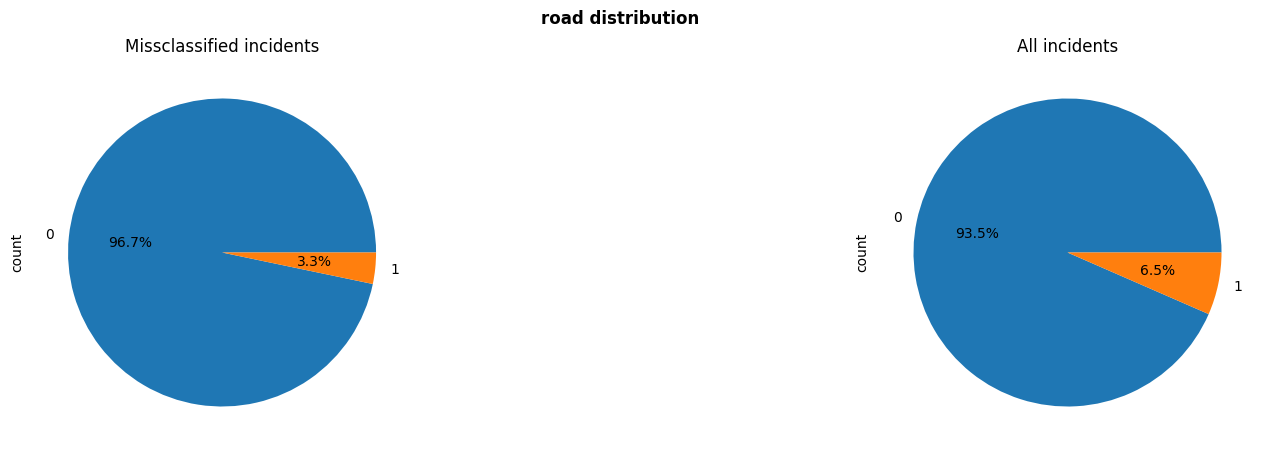

In [47]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_smote_test,
    incidents_test_df,
    'road',
    'pie',
    pie_perc_threshold=2,
    figsize=(20, 5),
    title='road distribution'
)

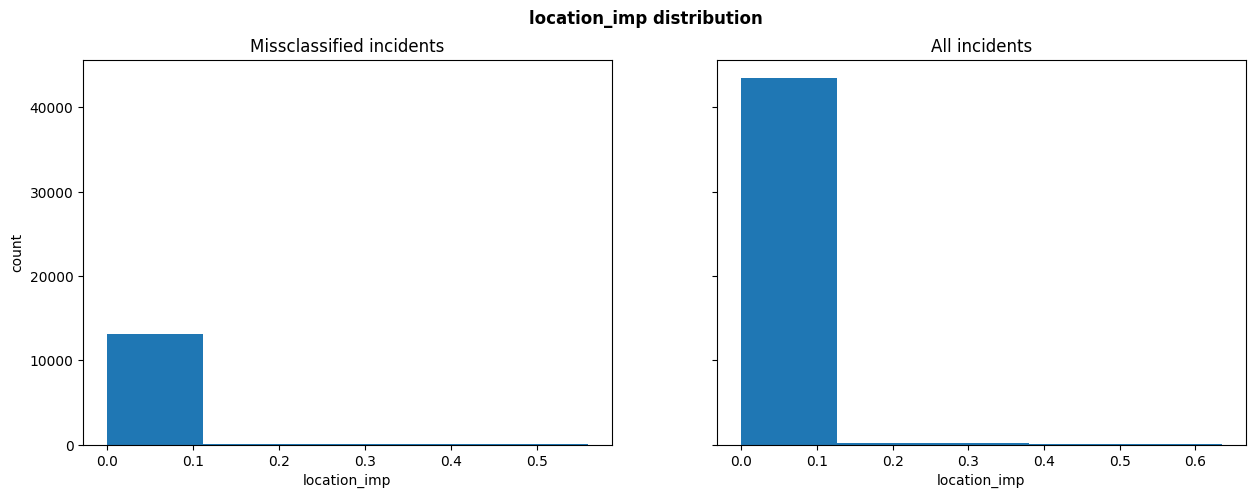

In [48]:
plot_distribution_missclassifications(
    true_labels_test,
    pred_labels_smote_test,
    incidents_test_df,
    'location_imp',
    'hist',
    bins=5,
    title='location_imp distribution'
)

We can notice that for **location_imp** and **n_killed** we have similar distribuition shapes. For **road**, **aggression**  and **suicide** we have that the percentage of misclassified incidents with the tag set to True is less than the one on the entire dataset, in particular there are very few miscassified incidents with **suicide** tag set to true.

## Final considerations
SVM is versatile type of model, in paticular with kernel function we can map input in a multi-dimensional space of the features, to have better performances and robusteness. In our use case this is confirmed since SVM has better scores than other distance based models like KNN and Neares Centroid. <br>
On the other hand it takes significantly more time for training and this could be a problem with huge datasets or when great computational power and hardware aren't available.